In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
sys.path.append("..")

## Illustration of Wasserstein Distance and Barycenters

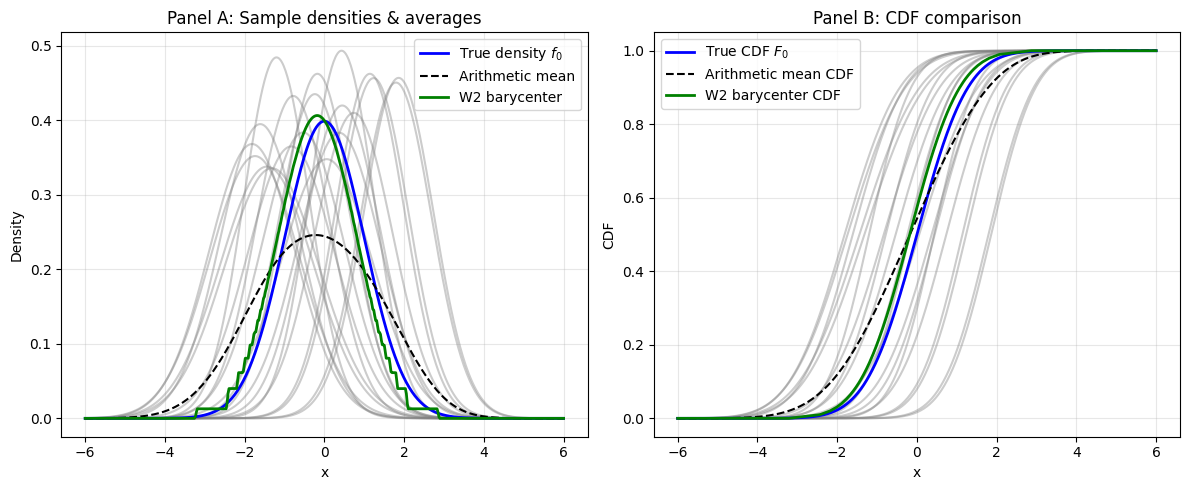

In [2]:
# --- Base distribution ---
f0 = norm.pdf
F0 = norm.cdf
q0 = norm.ppf

# --- Generate random (a,b) for location-scale model ---
n = 20
np.random.seed(42)
a = np.random.uniform(0.8, 1.2, size=n)   # scales
b = np.random.uniform(-2, 2, size=n)      # shifts

x = np.linspace(-6, 6, 500)
densities, cdfs = [], []

for i in range(n):
    fi = (1/a[i]) * f0((x - b[i]) / a[i])
    Fi = norm.cdf((x - b[i]) / a[i])
    densities.append(fi)
    cdfs.append(Fi)

densities = np.array(densities)
cdfs = np.array(cdfs)

# Arithmetic mean density & CDF
f_mean = densities.mean(axis=0)
F_mean = cdfs.mean(axis=0)

# Wasserstein barycenter via quantile averaging
u = np.linspace(0.001, 0.999, 100)
quantiles = np.array([a[i] * q0(u) + b[i] for i in range(n)])
q_bar = np.mean(quantiles, axis=0)

F_bar = np.interp(x, q_bar, np.linspace(0, 1, len(q_bar)))
f_bar = np.gradient(F_bar, x)

# True base
f_true = f0(x)
F_true = F0(x)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: sample densities
for fi in densities:
    axes[0].plot(x, fi, color="gray", alpha=0.4)
axes[0].plot(x, f_true, color="blue", linewidth=2, label="True density $f_0$")
axes[0].plot(x, f_mean, color="black", linestyle="--", label="Arithmetic mean")
axes[0].plot(x, f_bar, color="green", linewidth=2, label="W2 barycenter")
axes[0].set_title("Panel A: Sample densities & averages")
axes[0].set_xlabel("x"); axes[0].set_ylabel("Density")
axes[0].legend(); axes[0].grid(alpha=0.3)


# Panel B: CDFs
for Fi in cdfs:
    axes[1].plot(x, Fi, color="gray", alpha=0.4)
axes[1].plot(x, F_true, color="blue", linewidth=2, label="True CDF $F_0$")
axes[1].plot(x, F_mean, color="black", linestyle="--", label="Arithmetic mean CDF")
axes[1].plot(x, F_bar, color="green", linewidth=2, label="W2 barycenter CDF")
axes[1].set_title("Panel B: CDF comparison")
axes[1].set_xlabel("x"); axes[1].set_ylabel("CDF")
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
from src.clusterings import WassersteinKMeans, MomentKMeans, HMMClustering
from src.utils import *

## Example of Regime Segmentation Using Wasserstein K-Means / Moment K-Means / HMM using synthetic data

### Simple Synthetic Distributions (two regimes: low vs high variance)

In [4]:
# Example: synthetic distributions (two regimes: low vs high variance)
rng = np.random.default_rng(0)

X = []
for _ in range(30):
    X.append(rng.normal(.3, 1, size=100))   # regime 1
for _ in range(30):
    X.append(rng.normal(-.3, 1.2, size=100))   # regime 2

#### Wasserstein K-Means Clustering Results

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Label counts: [30 30]


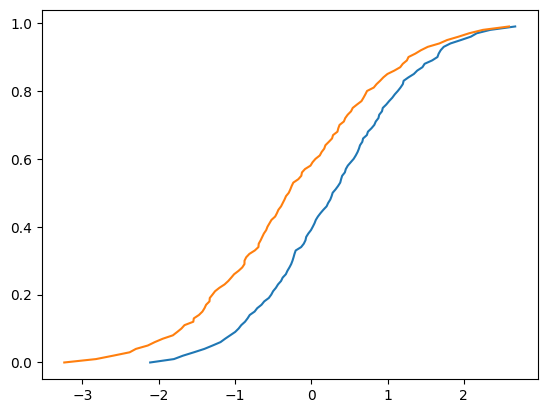

4 [np.float64(0.4591610328799746), np.float64(0.21974828972730792), np.float64(0.025130352470695422), np.float64(0.0)]


In [5]:
wkmeans = WassersteinKMeans(n_clusters=2, p=1, random_state=42)
result = wkmeans.fit(X)

print("Cluster labels:", result.labels)
print("Label counts:", np.bincount(result.labels))

plt.plot(result.centroids[0], np.arange(len(result.centroids[0])) / len(result.centroids[0]), label='Centroid 1')
plt.plot(result.centroids[1], np.arange(len(result.centroids[1])) / len(result.centroids[1]), label='Centroid 2')
plt.show()

print(result.iter, result.losses)

#### Moment K-Means Clustering Results

In [6]:
mkmeans = MomentKMeans(n_clusters=2, p_moments=4, random_state=42)
result = mkmeans.fit(X)

print("Cluster labels:", result.labels)
print("Label counts:", np.bincount(result.labels))

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Label counts: [33 27]


### Synthetic Price Data Regime Segmentation Example

In [7]:
# Synthetic demo: two regimes (low vol vs high vol)
rng = np.random.default_rng(1)
n_points = 1000
returns = np.concatenate([
    rng.normal(0, 0.01, size=n_points // 2),
    rng.normal(0, 0.05, size=n_points // 2),
])
prices = 100 * np.exp(np.cumsum(returns))
prices = np.concat([np.array([100]), prices])

# Segment returns
window, step = 50, 25
segments = segment_time_series(returns, window, step)

#### Wasserstein K-Means Clustering Results

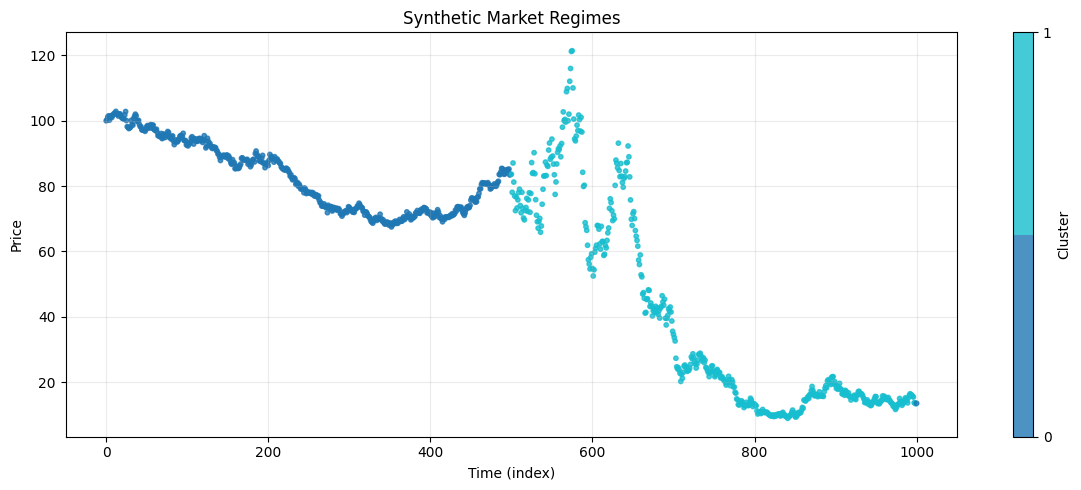

In [8]:
# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p=2, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, segments, result.labels, window, step, title="Synthetic Market Regimes")

#### Moment K-Means Clustering Results

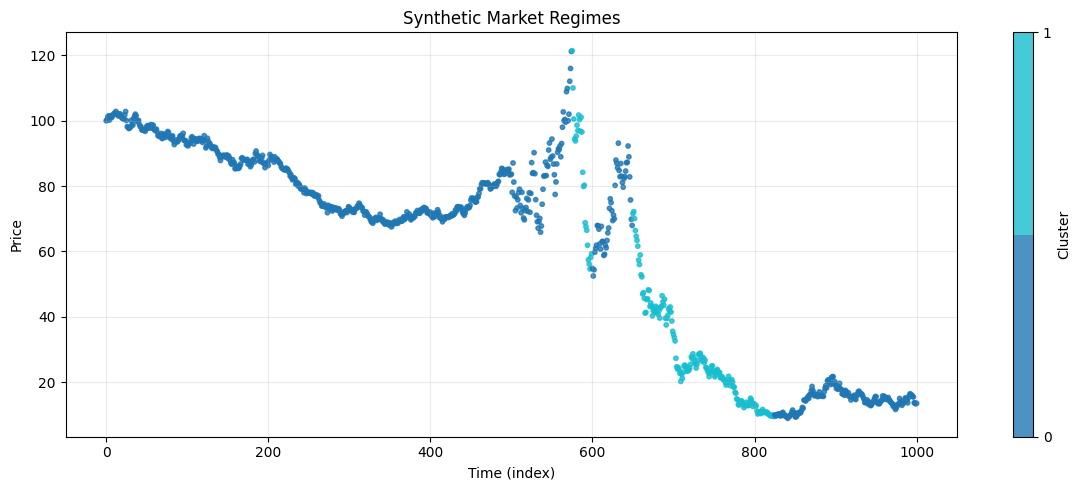

In [9]:
# Fit MK-means
mkmeans = MomentKMeans(n_clusters=2, p_moments=3, random_state=42)
result = mkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, segments, result.labels, window, step, title="Synthetic Market Regimes")

#### Hidden Markov Model Clustering Results

/opt/miniconda3/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


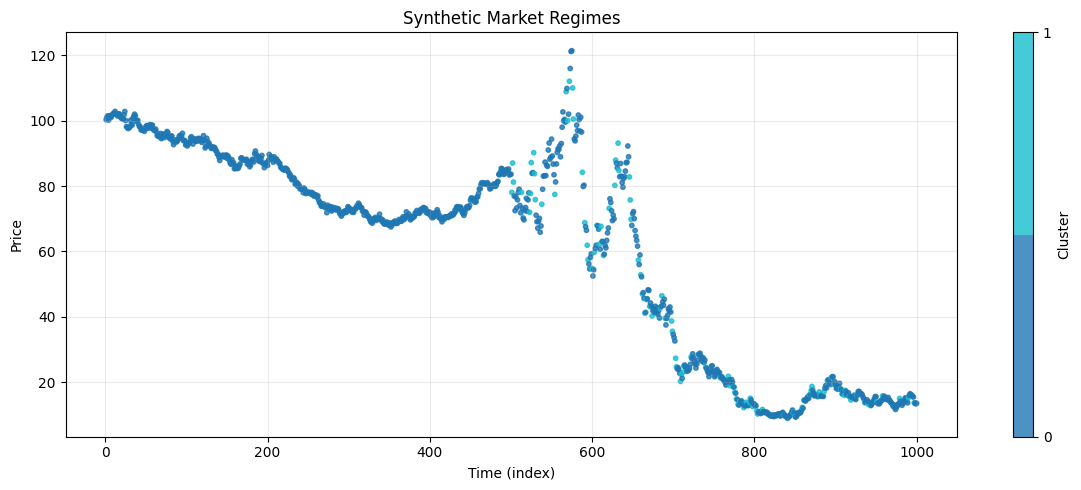

In [10]:
# Fit HMM clustering
hmm_cluster = HMMClustering(n_states=2, random_state=42)
result = hmm_cluster.fit(returns.reshape(-1, 1))

# Plot regimes
plot_regimes_over_price(prices, None, result.labels, window, step, title="Synthetic Market Regimes")

### Jump Diffusion Synthetic Data Regime Segmentation Example

In [11]:
def simulate_merton_jump_diffusion(
    T=1.0, N=252, S0=100, 
    mu=0.05, sigma=0.2, 
    lam=1.0, gamma=-0.1, delta=0.2,
    random_state=None
):
    """
    Simulate a Merton jump diffusion price path.

    Parameters
    ----------
    T : float
        Total time horizon.
    N : int
        Number of time steps.
    S0 : float
        Initial price.
    mu : float
        Drift term.
    sigma : float
        Volatility of diffusion part.
    lam : float
        Intensity (expected jumps per unit time).
    gamma : float
        Mean of log(1+V) jump size distribution.
    delta : float
        Std of log(1+V) jump size distribution.
    random_state : int or None
        Random seed for reproducibility.

    Returns
    -------
    times : ndarray
        Time grid.
    prices : ndarray
        Simulated price path.
    """
    if random_state is not None:
        np.random.seed(random_state)

    dt = T / N
    times = np.linspace(0, T, N+1)
    prices = np.zeros(N+1)
    prices[0] = S0

    for t in range(1, N+1):
        Z = np.random.normal(0, 1)
        # Diffusion part
        dW = np.sqrt(dt) * Z
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * dW

        # Jump part
        Nj = np.random.poisson(lam * dt)   # number of jumps
        if Nj > 0:
            jumps = np.sum(np.random.normal(gamma, delta, Nj))
        else:
            jumps = 0.0

        prices[t] = prices[t-1] * np.exp(drift + diffusion + jumps)

    return times, prices

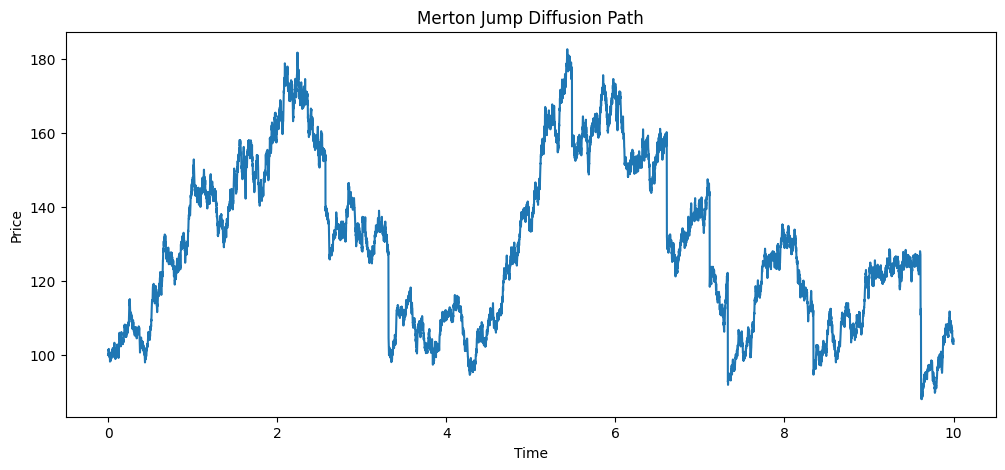

In [12]:
# Simulate a 2-year path with frequent jumps
times, prices = simulate_merton_jump_diffusion(
    T=10.0, N=10000, S0=100,
    mu=0.05, sigma=0.2,
    lam=2.0, gamma=-0.05, delta=0.1,
    random_state=42
)

returns = np.diff(np.log(prices))
window, step = 100, 25
segments = segment_time_series(returns, window, step)

plt.figure(figsize=(12, 5))
plt.plot(times, prices)
plt.title("Merton Jump Diffusion Path")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

#### Wasserstein K-Means Clustering Results

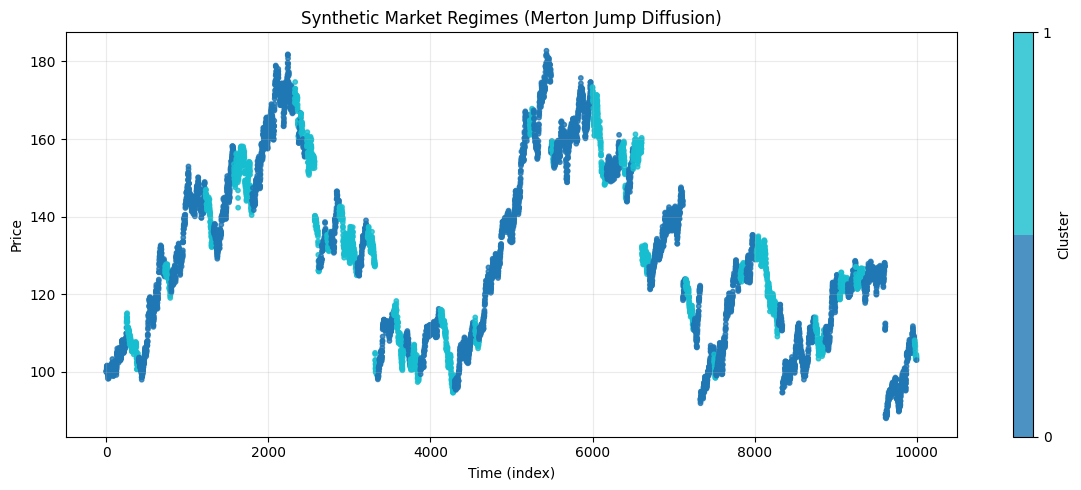

In [13]:
# Fit WK-means
wkmeans = WassersteinKMeans(n_clusters=2, p=1, random_state=42)
result = wkmeans.fit(segments)

# Plot regimes
plot_regimes_over_price(prices, segments, wkmeans.labels_, window, step, title="Synthetic Market Regimes (Merton Jump Diffusion)")

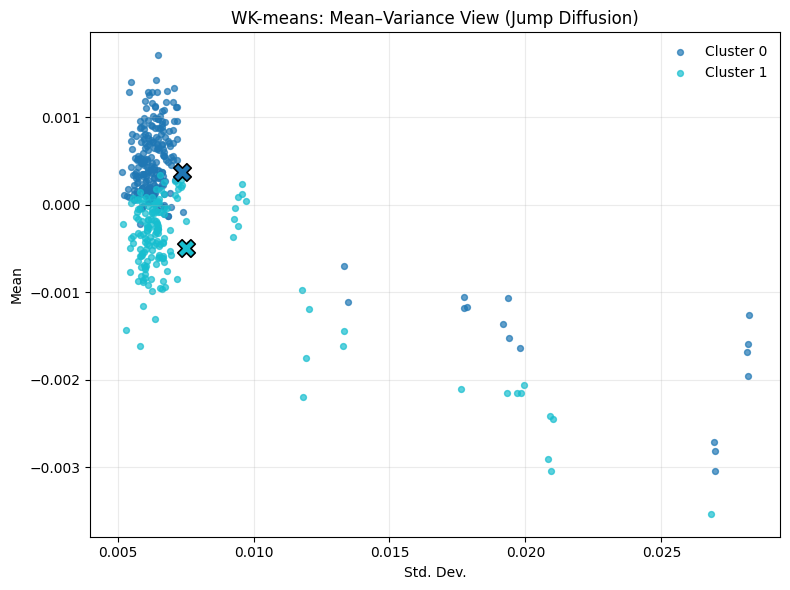

In [14]:
# Assuming you've already built `segments` and fitted `wkmeans` from earlier steps:
scatter_mean_variance(
    segments,
    result.labels,
    title="WK-means: Mean–Variance View (Jump Diffusion)",
)

## Real Financial Data Regime Segmentation Example (SPX)

In [15]:
# Read real financial data (SPX hourly)
spx = pd.read_csv("../data/SPX_hourly.csv", sep=";", header=None)
spx.columns = ["Date", "Hour", "Open", "High", "Low", "Close", "Volume"]
# Combine Date and Hour into a datetime index if needed
spx["Datetime"] = pd.to_datetime(spx["Date"] + " " + spx["Hour"], format="%d/%m/%Y %H:%M")
spx.set_index("Datetime", inplace=True)
# get data later than 2019-01-01
spx = spx[spx.index >= "2000-01-01"]

prices = spx["Close"].values.reshape(-1)
log_returns = np.diff(np.log(prices))

window, step = 72, 24
segments = segment_time_series(log_returns, window=window, step=step)

#### Wasserstein K-Means Clustering Results

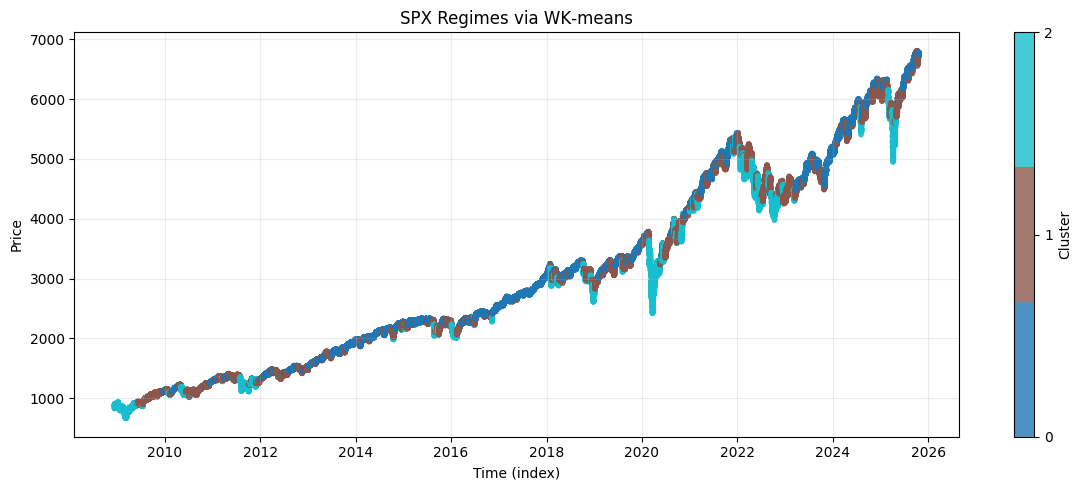

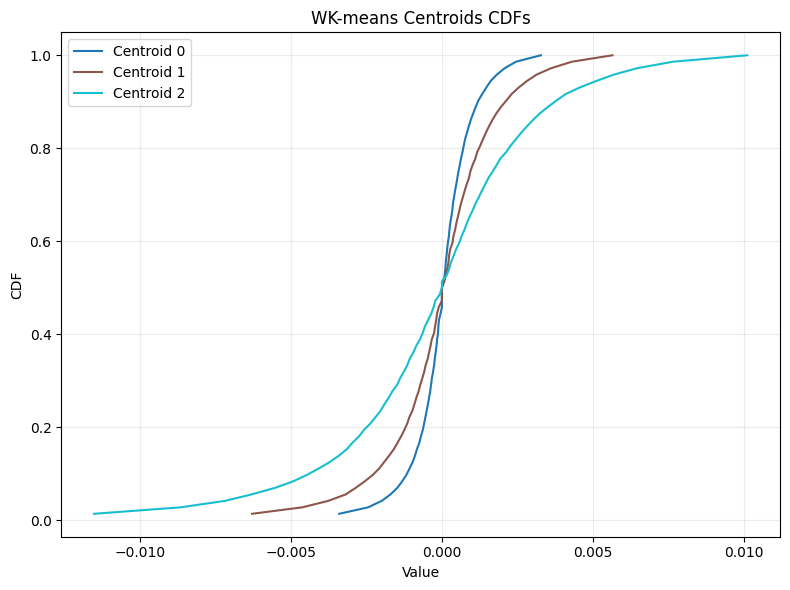

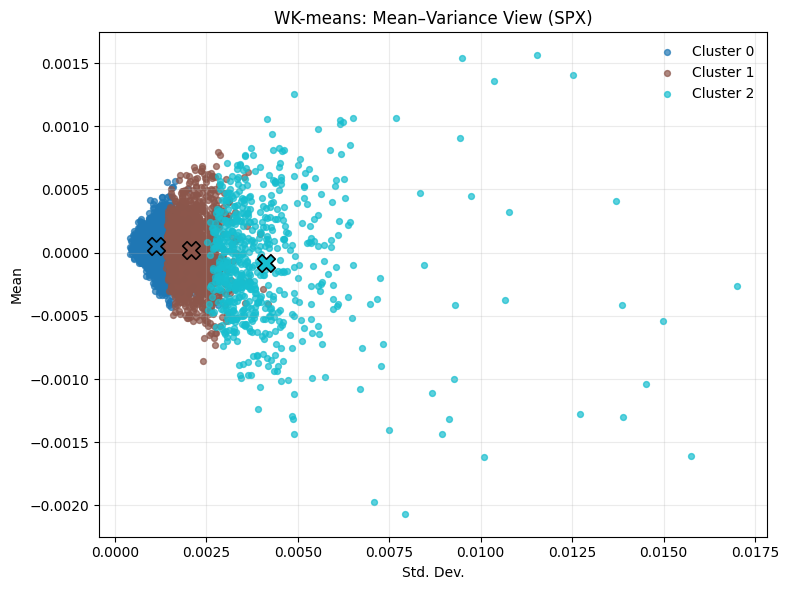

# of points in cluster 0 : 2060
# of points in cluster 1 : 1497
# of points in cluster 2 : 644


In [16]:
wk = WassersteinKMeans(n_clusters=3, p=1, random_state=42)
result = wk.fit(segments)

plot_regimes_over_price(prices, segments, result.labels, window, step, title="SPX Regimes via WK‐means", times=spx.index)
wk.plot_centroids_cdf(title="WK-means Centroids CDFs")
scatter_mean_variance(
    segments,
    result.labels,
    title="WK-means: Mean–Variance View (SPX)",
)

for i, cnt in enumerate(np.bincount(result.labels)):
    print("# of points in cluster", i, ":", cnt)

#### Moment K-Means Clustering Results

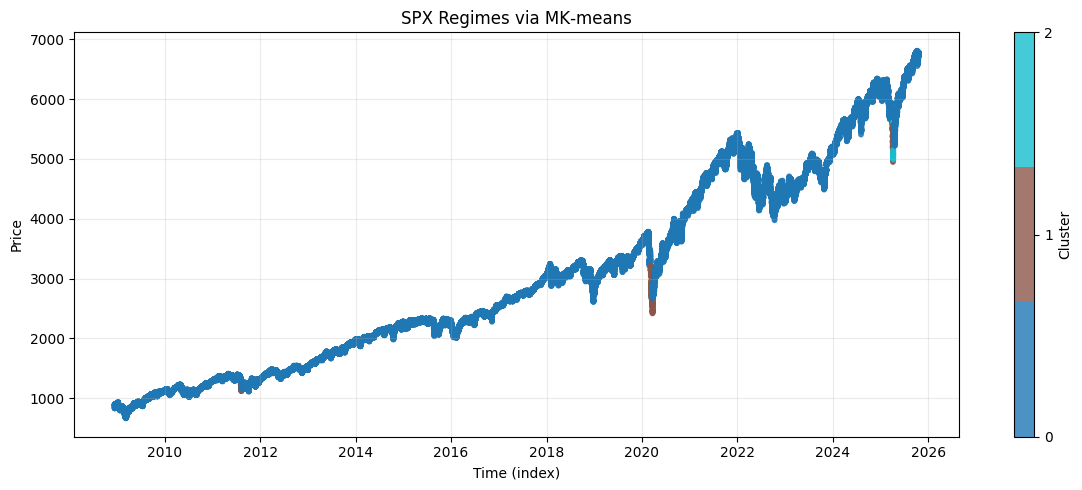

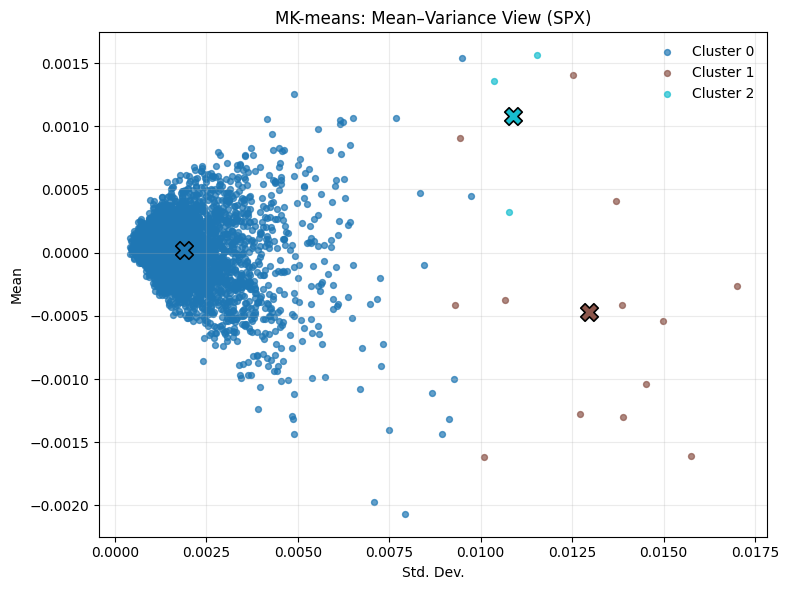

# of points in cluster 0 : 4185
# of points in cluster 1 : 13
# of points in cluster 2 : 3


In [17]:
mk = MomentKMeans(n_clusters=3, p_moments=3, random_state=42)
result = mk.fit(segments)

plot_regimes_over_price(prices, segments, result.labels, window, step, title="SPX Regimes via MK‐means", times=spx.index)
scatter_mean_variance(
    segments,
    result.labels,
    title="MK-means: Mean–Variance View (SPX)",
)

for i, cnt in enumerate(np.bincount(result.labels)):
    print("# of points in cluster", i, ":", cnt)

#### Hidden Markov Model Clustering Results

/opt/miniconda3/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


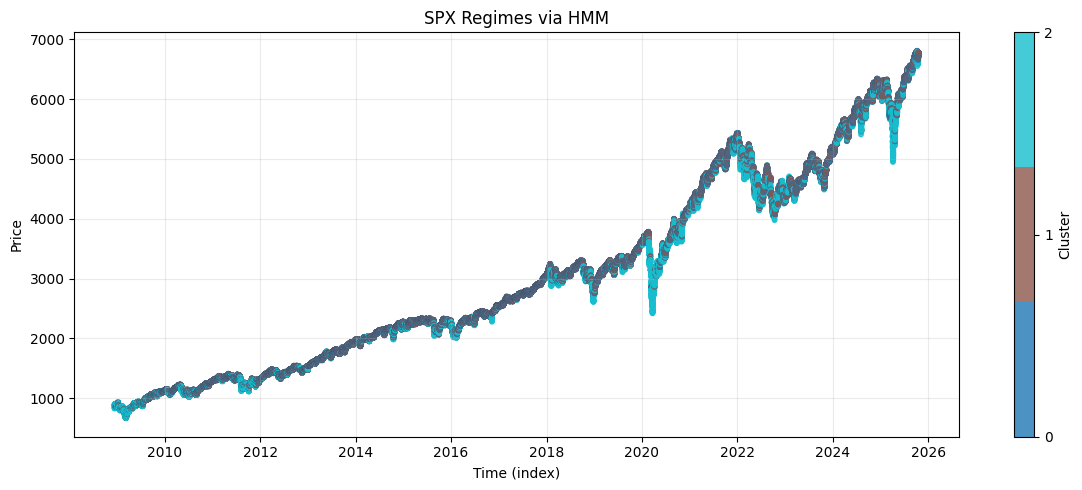

# of points in cluster 0 : 42208
# of points in cluster 1 : 42477
# of points in cluster 2 : 16201


In [18]:
hmm = HMMClustering(n_states=3, random_state=42)
result = hmm.fit(log_returns.reshape(-1, 1))

plot_regimes_over_price(prices, None, result.labels, window, step, title="SPX Regimes via HMM", times=spx.index)

for i, cnt in enumerate(np.bincount(result.labels)):
    print("# of points in cluster", i, ":", cnt)